### Load Data & libraries

In [59]:
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import seaborn as sns

# import LibESN
from LibESN.matrix_generator import matrixGenerator
from LibESN.esn import ESN
from LibESN.esn_fit import ridgeFit, ridgeCV
from LibESN.esn_forecast import forecast


In [62]:
# Load data
data = read_csv(r"C:\Users\zhouq\OneDrive - Nanyang Technological University\FYP\Codes\FYP\Data_transform.csv", header = 0, index_col=0, parse_dates=True, dayfirst=False)

# Select 3 exogenous variables 
# M1: Industrial Production Index
# M7: Retail and Food Services Sale
# M12: Effective Federal Funds Rate 

data_new = data[['GDP', 'M1', 'M7','M12']]
data_new = data_new.dropna()

# Split the data into training and testing sets
train_size = int(len(data_new) * 0.8)

GDP_fill_data  = pd.DataFrame(data_new['GDP'])
GDP_fill_data.index = GDP_fill_data.index + pd.offsets.QuarterEnd(0)
GDP_fill_data_train, GDP_fill_data_test = GDP_fill_data[:train_size], GDP_fill_data[train_size:]
display(GDP_fill_data)

x_data = pd.DataFrame(data_new.iloc[:, 1:])
x_data.index = x_data.index + pd.offsets.QuarterEnd(0)
x_train, x_test = x_data[:train_size], x_data[train_size:]
display(x_data)


,GDP
Date,
1959-06-30,0.022301
1959-09-30,0.000705
1959-12-31,0.002845
1960-03-31,0.022228
1960-06-30,-0.005405
...,...
2018-12-31,0.002229
2019-03-31,0.005960
2019-06-30,0.007898


,M1,M7,M12
Date,,,
1959-06-30,0.012391,0.005828,0.196667
1959-09-30,-0.019971,-0.002374,0.123333
1959-12-31,0.019589,-0.008020,0.076667
1960-03-31,0.002654,0.009733,-0.050000
1960-06-30,-0.007252,0.003164,-0.173333
...,...,...,...
2018-12-31,-0.000848,-0.002520,0.106667
2019-03-31,-0.003236,0.009089,0.046667
2019-06-30,-0.001557,0.003632,-0.010000


In [28]:
def normalize_train_test(train, test, return_mu_sig=False):
    m_train = train.mean()
    s_train = (train - train.mean()).std()
    if return_mu_sig:
        return (train - m_train)/s_train, (test - m_train)/s_train, m_train, s_train
    else:
        return (train - m_train)/s_train, (test - m_train)/s_train
    

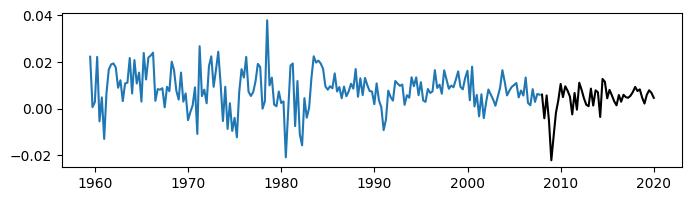

In [29]:
# plot dataset
plt.figure(figsize=(8,2))
plt.plot(GDP_fill_data_train, label = 'Train')
plt.plot(GDP_fill_data_test, label = 'Test', color = 'black')

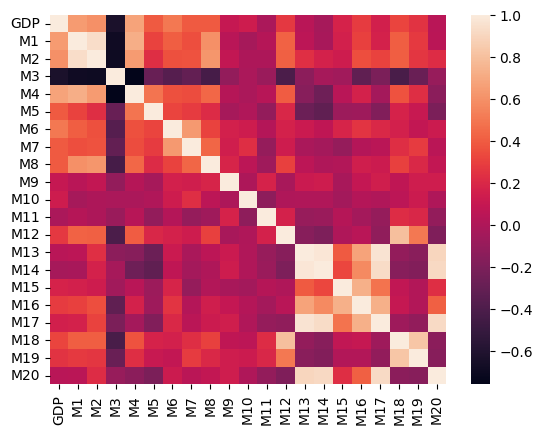

In [20]:
# check correlations between variables
corr_matrix_all = sns.heatmap(data.corr(), annot=False)

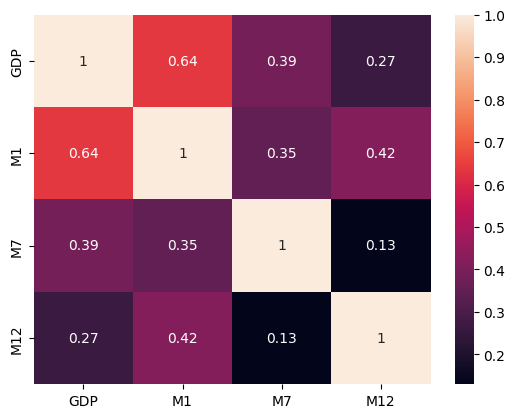

In [21]:
corr_matrix = sns.heatmap(data_new.corr(), annot=True)

### Models

#### ESN

In [94]:
from LibESN.matrix_generator import matrixGenerator
from LibESN.esn import ESN
from LibESN.esn_fit import ridgeFit, ridgeCV
from LibESN.esn_forecast import forecast

In [85]:
# construct individual ESN
# K is size of inputs 
K = int(x_data.shape[1])
print(int(x_data.shape[1]))

# build single reservoir ESN with reservoir dim = 30, sparsity = 10/30 (33.3%)

esn_a = ESN(
    None,
    smap=np.tanh, 
    A=matrixGenerator((30, 30), dist='sparse_normal', normalize= 'eig', sparsity=10/30, seed=1234), 

    C=matrixGenerator((30, K), dist='sparse_uniform', sparsity=10/30, normalize='norm2', seed=1234), 

    zeta=np.zeros((30, 1)), 
    rho=0.5, 
    gamma=1, 
    leak=0,
)


3


In [90]:
# ESN with reservoir dim = 120, sparsity = 10/120 (8.3%)
esn_b = ESN(
    None,
    smap=np.tanh, 
    A=matrixGenerator((120, 120), dist='sparse_normal', sparsity=10/120, normalize= 'eig', seed=1234), 

    C=matrixGenerator((120, K), dist='sparse_uniform', sparsity=10/120, normalize='norm2', seed=1234), 

    zeta=np.zeros((120, 1)), 
    rho=0.5, 
    gamma=1, 
    leak=0,
)


In [93]:
# ESN with reservoir dim = 250 > 193 (N > T), sparsity = 10/250 (4.0%)
esn_c = ESN(
    None,
    smap=np.tanh, 
    A=matrixGenerator((250 , 250), dist='sparse_normal', normalize= 'eig', sparsity=10/250, seed=1234), 

    C=matrixGenerator((250, K), dist='sparse_uniform', normalize='norm2', sparsity=10/250, seed=1234), 

    zeta=np.zeros((250, 1)), 
    rho=0.5, 
    gamma=1, 
    leak=0,
)


#### ARX

In [26]:
order = (1, 0, 0)  # AR(1)
model = ARIMA(endog=GDP_fill_data_train, exog=x_train, order=order)
fit = model.fit(method='yule_walker')

c:\Users\zhouq\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\zhouq\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\zhouq\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)


### Model Fitting and Fixed Parameter Forecast

##### ESN

In [33]:
def esn_fit(esnModel, GDP_data, exo_data):
    GDP_train, GDP_test = GDP_data[0], GDP_data[1]
    exo_train, exo_test = exo_data[0], exo_data[1]

    #normalize data
    GDP_train, GDP_test, GDP_mu_train, GDP_sig_train = (
        normalize_train_test(GDP_train, GDP_test,
            return_mu_sig=True))
    exo_train, exo_test = normalize_train_test(exo_train, exo_test)

    #cross validation to find lambda
    cv = ridgeCV().cv(model= esnModel, train_data=(exo_train, GDP_train), steps = 1, test_size = 5 )

    #fit model
    esnSingle_fit = esnModel.fit(train_data = (exo_train, GDP_train), method= ridgeFit(cv['cvLambda']), steps =1)

    #forecast
    esnSingle_for = forecast(model = esnModel, forecast_data=exo_test, fit=esnSingle_fit)

    #find RMSE
    mse = mean_squared_error(GDP_test, esnSingle_for['forecast'][0:len(GDP_test)])
    mae = mean_absolute_error(GDP_test, esnSingle_for['forecast'][0:len(GDP_test)])
    rmse = math.sqrt(mse)

    # plot 
    plt.figure(figsize=(8,2))
    plt.plot(data_new.index[:len(GDP_train)], GDP_train, label='Train')
    plt.plot(data_new.index[len(GDP_train):],GDP_test, label='Test')
    plt.plot(data_new.index[len(GDP_train):], esnSingle_for['forecast'][1:], label='Predictions')
    plt.grid()
    plt.show()

    # Compute pointwise forecasts
    esnSingle_fix_forecast = (esnSingle_for['forecast'][0]* GDP_sig_train.to_numpy() + GDP_mu_train.to_numpy())

    #output
    return({'Lambda': cv['cvLambda'], 'rmse': rmse, 'MAE':mae,'Point forecast': esnSingle_fix_forecast, 'forecast':esnSingle_for['forecast']})

                            

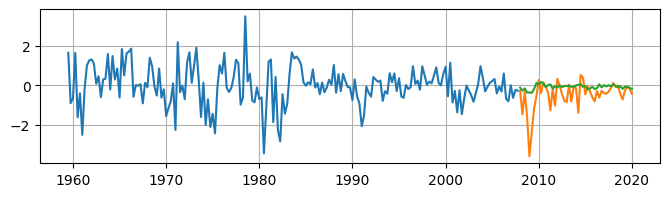

In [234]:
esn_fit_a = esn_fit(esn_a, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test])

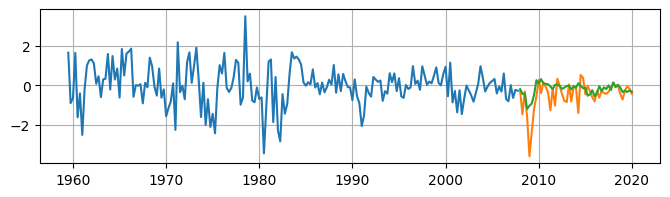

In [164]:
esn_fit_b = esn_fit(esn_b, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test])

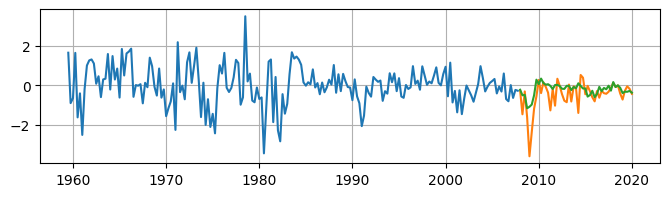

In [165]:
esn_fit_c = esn_fit(esn_c, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test])

In [236]:
rmse_a = esn_fit_a['rmse']
rmse_b = esn_fit_b['rmse']
rmse_c = esn_fit_c['rmse']
print("---------- RMSE --------------")
print(f"ESN_A \t = {rmse_a} \t")
print(f"ESN_B \t = {rmse_b} \t")
print(f"ESN_C \t = {rmse_c} \t")


---------- RMSE --------------
ESN_A 	 = 0.7701979861026044 	
ESN_B 	 = 0.6302009105032507 	
ESN_C 	 = 0.6220705482959777 	


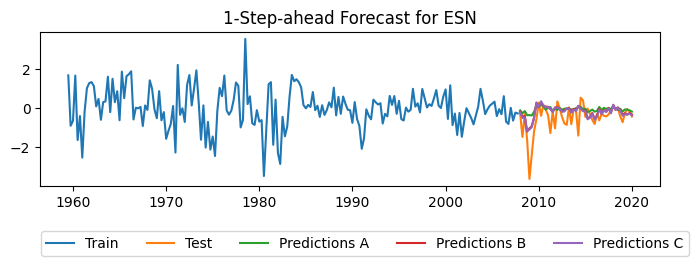

In [237]:
GDP_train, GDP_test, GDP_mu_train, GDP_sig_train = (
        normalize_train_test(GDP_train, GDP_test,return_mu_sig=True))

# Plot the actual vs. predicted values
plt.figure(figsize=(8,2))
plt.plot(data_new.index[:len(GDP_fill_data_train)], GDP_train, label='Train')
plt.plot(data_new.index[len(GDP_fill_data_train):],GDP_test, label='Test')
plt.plot(data_new.index[len(GDP_fill_data_train):], esn_fit_a['forecast'][1:], label='Predictions A')
plt.plot(data_new.index[len(GDP_fill_data_train):], esn_fit_b['forecast'][1:], label='Predictions B')
plt.plot(data_new.index[len(GDP_fill_data_train):], esn_fit_c['forecast'][1:], label='Predictions C')
plt.legend(bbox_to_anchor=(-0.01, -0.5), loc='lower left', ncol =5)
plt.title("1-Step-ahead Forecast for ESN")
plt.show()

#### ARX

In [35]:
# make predictions - one step ahead forecast
arx_forecast = fit.predict(start=len(x_train), end=len(data_new)-1, exog=x_test)

# Evaluate the model 
mse_arx = mean_squared_error(GDP_fill_data_test, arx_forecast)
print('MSE: '+str(mse_arx))

mae_arx = mean_absolute_error(GDP_fill_data_test, arx_forecast)
print('MAE: '+str(mae_arx))

rmse_arx = math.sqrt(mse_arx)
print('RMSE: '+str(rmse_arx))

MSE: 2.578817302342955e-05
MAE: 0.0036854222576466287
RMSE: 0.005078205689358156


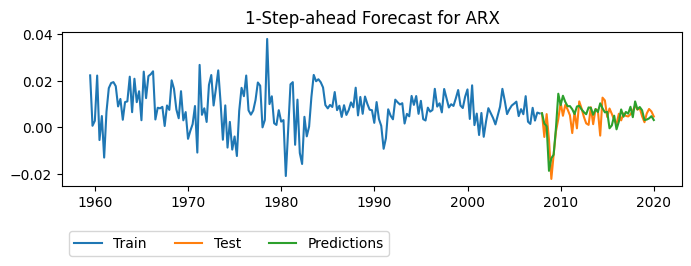

In [36]:
# Plot the actual vs. predicted values
plt.figure(figsize=(8,2))
plt.plot(data_new.index[:len(x_train)], GDP_fill_data_train, label='Train')
plt.plot(data_new.index[len(x_train):], GDP_fill_data_test, label='Test')
plt.plot(data_new.index[len(x_train):], arx_forecast, label='Predictions')
plt.title("1-Step-ahead Forecast for ARX")
plt.legend(bbox_to_anchor=(0, -0.5), loc='lower left', ncol =3)
plt.show()

### Expanding window forecast

#### ESN 

In [37]:
# data prep 
GDP_fill_data_train_j = pd.concat([
                GDP_fill_data_train, 
                GDP_fill_data_test.iloc[0:1,]
            ])


x_train_j = pd.concat([
                x_train, 
                x_test.iloc[0:1,]
            ])

display(GDP_fill_data_train_j)
display(x_train_j)


GDP_fill_data_test_j = GDP_fill_data_test.iloc[[1],]
x_test_j = x_test.iloc[[1],]

display(GDP_fill_data_test_j)
display(x_test_j)

,GDP
Date,
1959-06-30,0.022301
1959-09-30,0.000705
1959-12-31,0.002845
1960-03-31,0.022228
1960-06-30,-0.005405
...,...
2006-12-31,0.008402
2007-03-31,0.002932
2007-06-30,0.006364


,M1,M7,M12
Date,,,
1959-06-30,0.012391,0.005828,0.196667
1959-09-30,-0.019971,-0.002374,0.123333
1959-12-31,0.019589,-0.008020,0.076667
1960-03-31,0.002654,0.009733,-0.050000
1960-06-30,-0.007252,0.003164,-0.173333
...,...,...,...
2006-12-31,0.002802,0.004399,-0.003333
2007-03-31,0.002561,0.003127,0.006667
2007-06-30,0.002684,0.000903,-0.003333


,GDP
Date,
2008-03-31,-0.004083


,M1,M7,M12
Date,,,
2008-03-31,-0.002848,-0.001386,-0.543333


In [38]:
def esn_ew_fit(esnModel, Lambda, GDP_data, x_data, retune=False):
    GDP_fill_data_train = GDP_data[0]
    GDP_fill_data_test = GDP_data[1]

    x_train = x_data[0]
    x_test = x_data[1]

    GDP_test_dates = GDP_fill_data_test.index

    # recalculate lambdas
    if retune:  Lambdas = []

    forecast_ew = np.zeros((len(GDP_fill_data_test), 1))
    for j in tqdm(range(len(GDP_fill_data_test)), desc="EW", position=1, leave=False):
        if j > 0:
            #update data sets    
            GDP_fill_data_train_j = pd.concat([
                GDP_fill_data_train, 
                GDP_fill_data_test.iloc[0:j,]
            ])
            x_train_j = pd.concat([
                x_train, 
                x_test.iloc[0:j,]
            ])
            GDP_fill_data_test_j = GDP_fill_data_test.iloc[[j],]
            x_test_j = x_test.iloc[[j],]
        else:
            GDP_fill_data_train_j = GDP_fill_data_train
            x_train_j = x_train
            GDP_fill_data_test_j = GDP_fill_data_test.iloc[[0],]
            x_test_j = x_test.iloc[[0],]

        # Normalize
        GDP_fill_data_train_j, GDP_fill_data_test_j, mu_j, sig_j = (
            normalize_train_test(GDP_fill_data_train_j, GDP_fill_data_test_j,
                return_mu_sig=True)
        )
        x_train_j, x_test_j = (
            normalize_train_test(x_train_j, x_test_j)
        )

        if retune:
            Lambda_j = ridgeCV().cv(
                model= esnModel, 
                train_data=(x_train_j, GDP_fill_data_train_j), 
                steps = 1, 
                test_size = 5)
            
            Lambda_j = Lambda_j['cvLambda']
            Lambdas.append(Lambda_j)
            
        else:
            Lambda_j = Lambda

        #fit model
        esnSingle_fit = esnModel.fit(
            train_data = (x_train_j, GDP_fill_data_train_j), 
            method= ridgeFit(Lambda_j), 
            steps =1)

        #point forecast
        esnSingle_for = forecast(
            model = esnModel, 
            forecast_data=x_test_j, 
            fit=esnSingle_fit)

        forecast_ew[j] = (esnSingle_for['forecast'][0])* sig_j + mu_j #undo normalizing 
        #print(j)

    if retune:
        # plot list of updated lambdas
        plt.figure(figsize=(8,2))
        for l in range(len(Lambdas)):
            plt.plot(GDP_test_dates, np.log10(np.array([lam[l] for lam in Lambdas])))
        plt.ylabel("$\log_{10}(\lambda_t)$")
        plt.grid()
        plt.show()

    return pd.DataFrame(data=forecast_ew, index=GDP_test_dates,)
   

In [39]:
esnSingle_A_ew = esn_ew_fit(
    esnModel=esn_a, 
    Lambda=esn_fit_a['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

NameError: name 'esn_a' is not defined

In [288]:
# evaluate forcast
# display(GDP_fill_data_test)
mse_ew = mean_squared_error(GDP_fill_data_test,esnSingle_A_ew)
rmse_ew = math.sqrt(mse_ew)
print(rmse_ew)

0.006167369990143483


#### ARX

In [58]:
hist_exo._append(x_test.iloc[1,:],ignore_index=False)
hist_endo

,GDP
0,0.022301
1,0.000705
2,0.002845
3,0.022228
4,-0.005405
...,...
190,0.008402
191,0.002932
192,0.006364
193,0.006005


In [54]:
hist_exo = x_train.copy(deep=True)
hist_endo = GDP_fill_data_train.copy(deep=True)
arx_fore_ew = list()
 
for t in range(len(x_test)):
 # model set up and fit
 model = ARIMA(endog=hist_endo, exog=hist_exo, order=order)
 fit = model.fit(method='yule_walker')

 #point forecast -- undo norm
 output = fit.forecast(steps=1, exog = x_test.iloc[t,:])
 
 # update training dataset with observed data
 hist_exo = hist_exo._append(x_test.iloc[t,:],ignore_index=True)
 new_value = GDP_fill_data_test.iloc[t,]
 new_row = {col: new_value for col in hist_endo.columns}
 hist_endo = hist_endo._append(new_row, ignore_index=True)
 
 # add forecast value to list
 arx_fore_ew.append(output) 
 # obs = test.iloc[t,0] # actual
 # print('predicted=%f, actual=%f' % (output, obs))
 
# evaluate forecasts
arx_rmse_ew = math.sqrt(mean_squared_error(GDP_fill_data_test, arx_fore_ew))
print('RMSE: '+str(arx_rmse_ew))



c:\Users\zhouq\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\zhouq\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\zhouq\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

### Rolling Window Forecast

### Direct Mutli-step Forecast

#### ESN

In [334]:
# 8 steps ahead 
from LibESN.esn_forecast import forecastDirectMultistep
def esn_fit_multistep(esnModel, GDP_data, exo_data, n_step):
    GDP_train, GDP_test = GDP_data[0], GDP_data[1]
    exo_train, exo_test = exo_data[0], exo_data[1]

    #normalize data
    GDP_train, GDP_test, GDP_mu_train, GDP_sig_train = (
        normalize_train_test(GDP_train, GDP_test,
            return_mu_sig=True))
    exo_train, exo_test = normalize_train_test(exo_train, exo_test)

    #cross validation to find lambda
    cv = ridgeCV().cvDirectMultistep(
        model= esnModel, 
        train_data=(exo_train, GDP_train), 
        steps = n_step, 
        test_size = 5 )

    #fit model
    esn_fit_multi = esnModel.fitDirectMultistep(
        train_data = (exo_train, GDP_train), 
        method= ridgeFit(cv['cvLambda']), 
        steps =n_step)

    #forecast
    esn_for = forecastDirectMultistep(
        model = esnModel, 
        forecast_data=exo_test, 
        fit=esn_fit_multi)
    
    #undo norm
    esn_for['forecast'] = esn_for['forecast']* GDP_sig_train.to_numpy() + GDP_mu_train.to_numpy()

    # Compute pointwise forecasts
    esnSingle_fix_forecast = (esn_for['forecast'][0]* GDP_sig_train.to_numpy() + GDP_mu_train.to_numpy())

    #output
    return({'Lambda': cv['cvLambda'], 
            'Point forecast': esnSingle_fix_forecast, 
            'forecast':esn_for['forecast'],
            'fit': esn_fit_multi})

                            

In [335]:
esn_a_multistep = esn_fit_multistep(esn_a, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test], n_step = 8)

In [336]:
esn_b_multistep = esn_fit_multistep(esn_b, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test], n_step = 8)

In [337]:
def hStepRMSFE_2007(forecasts_df):
    T = len(forecasts_df)
    steps = len(forecasts_df.columns)
    hStep_rmse = np.zeros((steps))
    for h, c in enumerate(forecasts_df.columns):
        hStep_rmse[h] = np.sqrt(np.mean(np.square(
            np.squeeze(GDP_fill_data_test.to_numpy()) - forecasts_df[[c]].to_numpy()
        )[h:(T-steps+h+1)]))
    return pd.DataFrame(data=hStep_rmse, index=range(1, 1+steps))


In [338]:
esn_a_multi_for = np.squeeze(esn_a_multistep['forecast'])
esn_a_multi_for = pd.DataFrame(esn_a_multi_for)
display(esn_a_multi_for)
hStepRMSFE_2007(esn_a_multi_for)

,0,1,2,3,4,5,6,7
0,0.007514,0.008315,0.008701,0.008838,0.008638,0.009868,0.009431,0.008882
1,0.007318,0.008275,0.009025,0.008697,0.008868,0.009699,0.009845,0.008880
2,0.006053,0.008311,0.008756,0.009018,0.008953,0.010291,0.010191,0.009139
3,0.007018,0.008303,0.008827,0.008940,0.008959,0.010054,0.010085,0.009051
4,0.005243,0.008271,0.008119,0.008693,0.008804,0.009717,0.009548,0.009054
5,0.005266,0.008246,0.008301,0.008614,0.008750,0.009216,0.009817,0.008942
6,0.005132,0.008268,0.008230,0.008704,0.008740,0.009715,0.009662,0.009041
7,0.006706,0.008284,0.008421,0.008775,0.008882,0.009824,0.009976,0.008913
8,0.009360,0.008320,0.009489,0.009171,0.008856,0.009736,0.009739,0.008850
9,0.008701,0.008315,0.009378,0.008762,0.008535,0.009396,0.009079,0.008661


,0
1,0.007025
2,0.007267
3,0.007608
4,0.007542
5,0.007508
6,0.007979
7,0.007977
8,0.007564


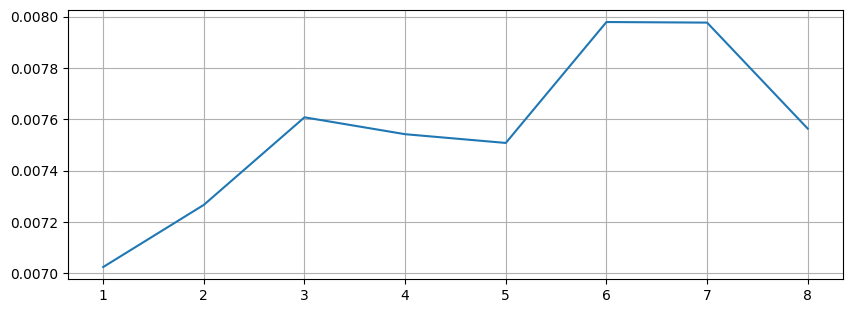

In [339]:
fig, ax = plt.subplots(figsize=(10, 3.5))
plt.grid()
plt.plot(hStepRMSFE_2007(esn_a_multi_for), label="singleESN [A]", c="C0") 


In [341]:
esn_b_multi_for = np.squeeze(esn_b_multistep['forecast'])
esn_b_multi_for = pd.DataFrame(esn_b_multi_for)
display(esn_b_multi_for)
hStepRMSFE_2007(esn_b_multi_for)

,0,1,2,3,4,5,6,7
0,0.007448,0.008297,0.008371,0.008321,0.008899,0.008348,0.009058,0.008524
1,0.006695,0.008331,0.008383,0.008464,0.009636,0.008368,0.009667,0.008612
2,0.004634,0.008320,0.008380,0.008635,0.010844,0.008410,0.010618,0.008767
3,0.004873,0.008001,0.008074,0.008516,0.009978,0.008382,0.009862,0.008659
4,-0.001779,0.006821,0.006963,0.008662,0.009209,0.008397,0.009738,0.008856
5,-0.000428,0.007234,0.007723,0.009074,0.010652,0.008447,0.012337,0.009027
6,0.000522,0.007029,0.007372,0.008675,0.009235,0.008399,0.010435,0.008794
7,0.004294,0.007709,0.007793,0.008158,0.008485,0.008346,0.008100,0.008515
8,0.010497,0.008565,0.008802,0.008550,0.008834,0.008336,0.010011,0.008501
9,0.009095,0.008456,0.008511,0.008188,0.008318,0.008328,0.008500,0.008417


,0
1,0.007018
2,0.007149
3,0.007200
4,0.007296
5,0.007359
6,0.007291
7,0.007570
8,0.007383


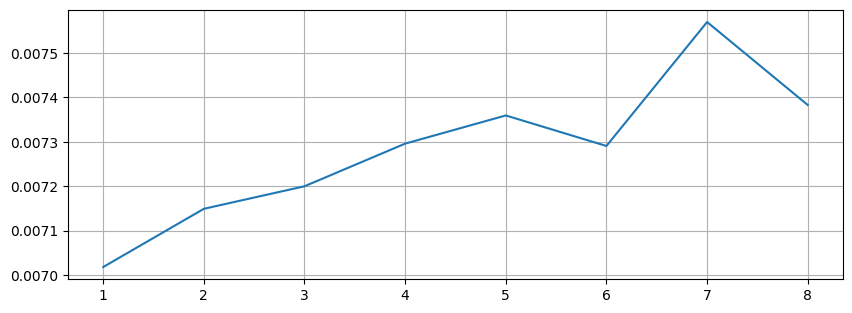

In [343]:
fig, ax = plt.subplots(figsize=(10, 3.5))
plt.grid()
plt.plot(hStepRMSFE_2007(esn_b_multi_for), label="singleESN [B]", c="C0") 

#### ARX